In [1]:
from __future__ import print_function

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import regularizers

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
from tensorflow.keras import backend as K
# assert len(backend.tensorflow_backend._get_available_gpus()) > 0

# Perform the search

In [4]:
costs = pd.read_csv("~/code/fifteen-puzzle/data/datasets/15-costs-v1.csv", nrows=4000000)
costs.shape

(4000000, 17)

In [5]:
costs.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,cost
0,13,4,7,15,8,0,2,1,9,6,10,14,3,12,5,11,56
1,10,2,4,12,3,13,8,0,1,5,6,7,14,9,11,15,34
2,8,15,11,14,13,5,6,7,4,9,12,0,1,2,10,3,59
3,1,0,10,6,2,3,14,8,9,7,4,13,5,11,12,15,43
4,1,5,6,8,3,4,9,14,11,10,2,12,13,15,0,7,41


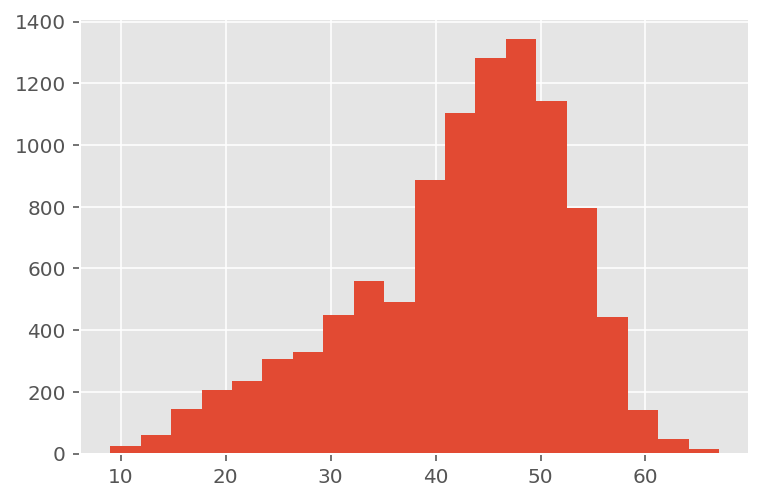

In [6]:
costs.sample(10000).cost.hist(bins=20);

In [7]:
X_raw = costs.iloc[:,:-1].values
y = costs['cost'].values

In [8]:
X = np.apply_along_axis(lambda x: np.eye(16)[x].ravel(), 1, X_raw)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
def asymmetric_mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true) * K.square(K.sign(y_pred - y_true) + 0.4), axis=-1)

def get_model(layer_sizes, 
              learning_rate=0.001, 
              dropout_ratio=0.2, 
              activation='elu', 
              loss='mean_squared_error',
              kernel_initializer='he_normal', 
              batch_normalize=True,
              kernel_regularizer=None):
    model = Sequential()
    model.add(Dense(layer_sizes[0], 
                    input_shape=(256,), 
                    activation=activation, 
                    kernel_initializer=kernel_initializer,
                    kernel_regularizer=kernel_regularizer))
    model.add(Activation(activation))
    if batch_normalize:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_ratio))
    
    for layer_size in layer_sizes[1:]:
        model.add(Dense(layer_size, 
                        activation=activation, 
                        kernel_initializer=kernel_initializer,
                        kernel_regularizer=kernel_regularizer))
        model.add(Activation(activation))
        if batch_normalize:
            model.add(BatchNormalization())
        model.add(Dropout(dropout_ratio))

    model.add(Dense(1, kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer))
    model.compile(loss=loss,
                  optimizer=Adam(lr=learning_rate),
                  metrics=['accuracy'])
    return model

In [11]:
params_layer_sizes = [
#     [1024, 512, 256],
#     [2048, 1024, 512],
#     [1024, 512, 256, 128],
#     [2048, 1024, 512, 256],
    [1024, 512, 256, 128, 64],
#     [2048, 1024, 512, 256, 128],
#     [1024, 512, 256, 128, 64, 32],
#     [2048, 1024, 512, 256, 128, 64],
#     [1024, 512, 256, 128, 64, 32, 16],
#     [2048, 1024, 512, 256, 128, 64, 32]
]

params_dropout = [0.2]

params_regularizer = [regularizers.l2(0.000001), regularizers.l2(0.00001)]

results_history = dict()

In [12]:
for layer_sizes in params_layer_sizes:
    for dropout in params_dropout:
        for regularizer in params_regularizer:
            name = f"layers: {layer_sizes}, dropout: {dropout}"
            print(f"### ANN TRAINING STARTED, {name} ###")

            early_stopping = tf.keras.callbacks.EarlyStopping(patience=2, verbose=0, restore_best_weights=False)

            model = get_model(layer_sizes, 
                              learning_rate=0.03, 
                              dropout_ratio=dropout,
                              loss=asymmetric_mean_squared_error,
                              kernel_regularizer=regularizer)

            history = model.fit(X_train, y_train,
                                batch_size=256,
                                epochs=5,
                                verbose=1,
                                validation_data=(X_valid, y_valid),
                                callbacks=[early_stopping])

            val_loss = min(history.history['val_loss'])
            n_epochs = len(history.history['val_loss'])
            results = f"val_loss: {val_loss}, n_epochs: {n_epochs}"
            print(f"### ANN TRAINING ENDED, {results} ###")
            results_history[name] = results

### ANN TRAINING STARTED, layers: [1024, 512, 256, 128, 64], dropout: 0.2 ###
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 3200000 samples, validate on 800000 samples
Epoch 1/5
3200000/3200000 [==============================] - 866s 271us/sample - loss: 8.5904 - acc: 6.2500e-07 - val_loss: 3.8974 - val_acc: 0.0000e+00
Epoch 2/5
3200000/3200000 [==============================] - 873s 273us/sample - loss: 5.5754 - acc: 6.2500e-07 - val_loss: 3.7264 - val_acc: 0.0000e+00
Epoch 3/5
3200000/3200000 [==============================] - 861s 269us/sample - loss: 5.3773 - acc: 6.2500e-07 - val_loss: 4.5093 - val_acc: 0.0000e+00
Epoch 4/5
3200000/3200000 [==============================] - 869s 272us/sample - loss: 5.2749 - acc: 3.1250e-07 - val_loss: 3.9990 - val_acc: 0.0000e+00
### ANN TRAINING ENDED, val_loss: 3.7263705921936037, n_epochs: 4 ###
### ANN TRAINING STARTED, layers: [1024, 512, 256, 128, 64], dropout: 0.2 ###
Train on 3200000 samples, va

In [13]:
results_history

{'layers: [1024, 512, 256, 128, 64], dropout: 0.2': 'val_loss: 5.033572533721924, n_epochs: 4'}

# Results

layers: [1024, 512, 256, 128], dropout: 0.2, val_loss: 2.537219319267273, n_epochs: 3

layers: [1024, 512, 256, 128], dropout: 0.4, val_loss: 2.3189011152648926, n_epochs: 4

layers: [1024, 512, 256, 128, 64], dropout: 0.2, val_loss: 2.167449114265442, n_epochs: 4

layers: [1024, 512, 256, 128, 64], dropout: 0.4, val_loss: 2.9026869491577147, n_epochs: 3

layers: [2048, 1024, 512, 256, 128], dropout: 0.2, val_loss: 2.151426022758484, n_epochs: 4

layers: [1024, 512, 256, 128, 64, 32], dropout: 0.2, val_loss: 2.3699882026672365, n_epochs: 4

layers: [1024, 512, 256, 128, 64, 32], dropout: 0.4, val_loss: 2.7748224792861937, n_epochs: 4

layers: [1024, 512, 256, 128, 64, 32, 16], dropout: 0.2, val_loss: 2.4911141011428835, n_epochs: 4

layers: [1024, 512, 256, 128, 64, 32, 16], dropout: 0.4, val_loss: 2.9838143817138674, n_epochs: 4

layers: [1024, 512, 256, 128, 64], dropout: 0.2, l2: 0.000001, val_loss: 3.7263705921936037, n_epochs: 4

layers: [1024, 512, 256, 128, 64], dropout: 0.2, l2: 0.00001, val_loss: 5.033572533721924, n_epochs: 4